# Lab 3: Generating Data

Based on assignments by Lisa Zhang and Jimmy Ba.

In this lab, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded. 

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.


### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:
https://colab.research.google.com/drive/1_4Jt6_7yxcf4Eunhp-ItTy8va0LXH-4w?usp=sharing

# PART A - Autoencoder [20 pt]

In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [1]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# for consistent outputs
torch.manual_seed(1517)
npr.seed(1517)

In [2]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [3]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [4]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz


## Part 1. Data Preparation [7 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks. 

### Part (a) [1pt]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [5]:
# code to examine the dataset
print('type of variable m:',type(m))
print('number of entries in m:',len(m))
print('type of entries of m:',type(m[1]))
print('type of entry of images:',type(m[0][0]))
print('type of enty of labels:',type(m[0][1]))
print('dimensions of training images:',m[0][0].shape)
print('dimensions of training labels:',m[0][1].shape)
print('dimensions of testing images:',m[1][0].shape)
print('dimensions of testing labels:',m[1][1].shape)
print('example label:')
print(m[0][1][0])
print('example image:')
print(m[0][0][0])

type of variable m: <class 'tuple'>
number of entries in m: 2
type of entries of m: <class 'tuple'>
type of entry of images: <class 'numpy.ndarray'>
type of enty of labels: <class 'numpy.ndarray'>
dimensions of training images: (50000, 3, 32, 32)
dimensions of training labels: (50000, 1)
dimensions of testing images: (10000, 3, 32, 32)
dimensions of testing labels: (10000, 1)
example label:
[6]
example image:
[[[ 59  43  50 ... 158 152 148]
  [ 16   0  18 ... 123 119 122]
  [ 25  16  49 ... 118 120 109]
  ...
  [208 201 198 ... 160  56  53]
  [180 173 186 ... 184  97  83]
  [177 168 179 ... 216 151 123]]

 [[ 62  46  48 ... 132 125 124]
  [ 20   0   8 ...  88  83  87]
  [ 24   7  27 ...  84  84  73]
  ...
  [170 153 161 ... 133  31  34]
  [139 123 144 ... 148  62  53]
  [144 129 142 ... 184 118  92]]

 [[ 63  45  43 ... 108 102 103]
  [ 20   0   0 ...  55  50  57]
  [ 21   0   8 ...  50  50  42]
  ...
  [ 96  34  26 ...  70   7  20]
  [ 96  42  30 ...  94  34  34]
  [116  94  87 ... 14

Answer:<br>
<font color='blue'>
Yes, the dataset has been loaded correctly.
<br><br>
we have 50000 training samples, and 10000 test samples, so 60000 samples in total.
<br><br>
The tuple variable m contains the dataset. Tuple m has two entries. <br>
The first entry of tuple m is a also tuple of size 2: the first entry is a numpy array of shape 50000 * 3 * 32 * 32 (50000 RGB images of size 32 * 32), the second entry is a numpy array of shape 50000 * 1 (corresponding 50000 labels of the training set images). <br>
The second entry of tuple m is a also tuple of size 2: the first entry is a numpy array of shape 10000 * 3 * 32 * 32 (10000 RGB images of size 32 * 32), the second entry is a numpy array of shape 10000 * 1 (corresponding 10000 labels of the test set images). 

</font>

### Part (b) [2pt]
Preprocess the data to select only images of horses. Learning to generate only hourse images will make our task easier. Your function will also convert the colour images to greyscale to create our input data.

In [6]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


<font color='blue'>
The preprocessing function is already provided in the cell above.
Based on discussion on Piazza, nothing needs to be done here. (free points)
</font>

### Part (c) [2pt]
Create a dataloader (or function) to batch the samples.

In [7]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

<font color='blue'>
The dataloader implementation is already provided in the cell above.
Based on discussion on Piazza, nothing needs to be done here. (free points)
</font>

### Part (e) [2pt]
Verify and visualize that we are able to generate different batches of data.

In [8]:
# code to load different batches of horse dataset (with random seed added for consistent result)
npr.seed(1517)

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [9]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [10]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


In [11]:
# added part: splitting the train data into training set and validation set
# take the last 20% as validation (train_rgb has been shuffled already)
val_rgb = train_rgb[4000:,:,:,:]
val_grey = train_grey[4000:,:,:,:]
train_rgb = train_rgb[0:4000,:,:,:]
train_grey = train_grey[0:4000,:,:,:]

# shape of training set data
print('Training Data: ', train_rgb.shape, train_grey.shape)

# shape of validation set data
print('Validation Data: ', val_rgb.shape, val_grey.shape)

# shape of testing set data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (4000, 3, 32, 32) (4000, 1, 32, 32)
Validation Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [12]:
# obtain batches of images
xs, ys = next(iter(get_batch(train_grey, train_rgb, 10)))
print(xs.shape, ys.shape)

(10, 1, 32, 32) (10, 3, 32, 32)


Visualization

5 train/test images in color:


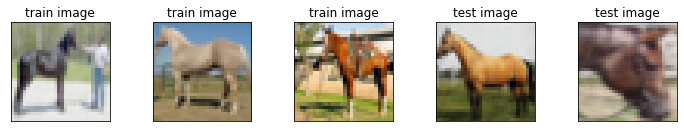

5 train/test images in gray scale


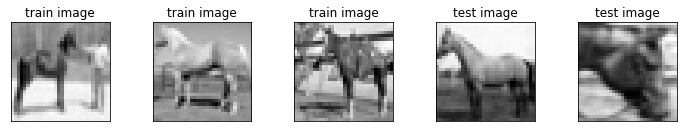

In [13]:
# visualize 5 train/test images
# obtain one batch of trian images (xs1,ys1) and one batch of test images (xs2,ys2)
xs1, ys1 = next(iter(get_batch(train_grey, train_rgb, 10)))
xs2, ys2 = next(iter(get_batch(test_grey, test_rgb, 10)))

print('5 train/test images in color:')

# plot 3 train images in color
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(ys1[idx,:,:,:], (1, 2, 0)))
    ax.set_title('train image')

# plot 2 test images in color
for idx in np.arange(3,5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(ys2[idx-2,:,:,:], (1, 2, 0)))
    ax.set_title('test image')
plt.show()

print('5 train/test images in gray scale')

# plot the 3 test images in gray scale
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(xs1[idx,0,:,:],cmap='gray')
    ax.set_title('train image')

# plot 2 test images in gray scale
for idx in np.arange(3,5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(xs2[idx-2,0,:,:],cmap='gray')
    ax.set_title('test image')
plt.show()



<font color='blue'>
Yes, we are able to generate different batches of data.
</font>

## Part 2. Colourization as Regression [5 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will get familar with training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [14]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [15]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def MSELoss_dataset_evaluator(model,data_rgb,data_grey,gpu): 
    ys = data_rgb
    xs = data_grey
    criterion = nn.MSELoss()
    images, labels = get_torch_vars(xs, ys, gpu)
    outputs = model(images)
    loss = criterion(outputs, labels)
    return loss.data.item()


# modified from the provided train function
def train(args, train_rgb, train_grey, val_rgb, val_grey, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        
        print(epoch, loss.cpu().detach())
        if args.plot:
          visual(images, labels, outputs, args.gpu, 1)
        
    return gen

# with extra task: calculate losses at each epoch and return the losses
def train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()
    train_losses = []
    valid_losses = []
    valid_accs = []
    
    # fix a batch of 10 images for the purpose of displaying output images
    for i, (display_xs, display_ys) in enumerate(get_batch(train_grey, train_rgb, 100)):
        display_images, display_labels = get_torch_vars(display_xs, display_ys, args.gpu)

    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        
        print(epoch, loss.cpu().detach())
    
        # calculate training loss and validation loss
        train_losses.append(MSELoss_dataset_evaluator(gen,train_rgb,train_grey,args.gpu))
        valid_losses.append(MSELoss_dataset_evaluator(gen,val_rgb,val_grey,args.gpu))
    
    # only output images after training
    display_outputs = gen(display_images)
    if args.plot:
        visual(display_images, display_labels, display_outputs, args.gpu, 1)

    return gen, train_losses, valid_losses



Training visualization code

In [16]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

Beginning training ...
0 tensor(0.0679)
1 tensor(0.0264)
2 tensor(0.0205)
3 tensor(0.0179)
4 tensor(0.0163)
5 tensor(0.0149)
6 tensor(0.0140)
7 tensor(0.0135)
8 tensor(0.0130)
9 tensor(0.0124)
10 tensor(0.0120)
11 tensor(0.0116)
12 tensor(0.0113)
13 tensor(0.0110)
14 tensor(0.0108)
15 tensor(0.0105)
16 tensor(0.0103)
17 tensor(0.0101)
18 tensor(0.0099)
19 tensor(0.0098)
20 tensor(0.0096)
21 tensor(0.0095)
22 tensor(0.0094)
23 tensor(0.0093)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0092)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


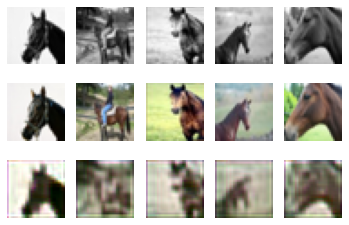

In [17]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn, train_losses_cnn, val_losses_cnn = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [18]:
# results of cnn
print('Losses of cnn')
print('Training Loss:',MSELoss_dataset_evaluator(cnn,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn,val_rgb,val_grey,True))

Losses of cnn
Training Loss: 0.01015168521553278
Validation Loss: 0.010088035836815834


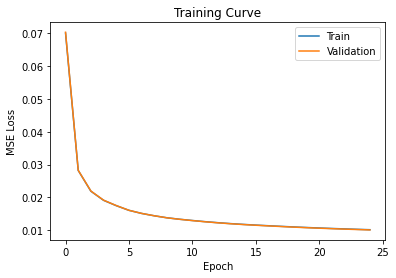

In [19]:
# training curve of cnn
plt.title("Training Curve")
plt.plot(range(25), train_losses_cnn, label="Train") # 1st epoch is epoch 0
plt.plot(range(25), val_losses_cnn, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

<font color='red'>
<br>
Note: two curves are plotted, but just they are very close.
</font>

### Part (a) [1 pt]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer? Construct a table or draw a diagram.

Answer:
<br>
<font color='blue'>
The model RegressionCNN has 6 convolution layers. <br>
The table below shows the filter size and number of filters at each layer:
</font>


| Layer # | Layer Name | Filter Size | Number of Filters
| --- | --- | --- | --- |
| 1 | downconv1 | 3 by 3 by 1 (in_channel) | 32 |
| 2 | downconv2 | 3 by 3 by 32 (in_channel) | 64 |
| 3 | rfconv | 3 by 3 by 64 (in_channel) | 64 |
| 4 | upconv1 | 3 by 3 by 64 (in_channel) | 32 |
| 5 | upconv2 | 3 by 3 by 32 (in_channel) | 3 |
| 6 | finalconv | 3 by 3 by 3 (in_channel) | 3 |

### Part (b) [1 pt]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting?

Answer: 
<font color='blue'>
<br>
25 epochs in the given setting. The regression training code is already run at a notebook cell (under Main training loop for regression CNN) before part a of part 2. The code to run the train function is provided there.
</font>

### Part (c) [3 pt]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

<font color='blue'>
RegressionCNN with 50 epochs
</font>

Beginning training ...
0 tensor(0.0229)
1 tensor(0.0162)
2 tensor(0.0139)
3 tensor(0.0124)
4 tensor(0.0115)
5 tensor(0.0108)
6 tensor(0.0103)
7 tensor(0.0100)
8 tensor(0.0097)
9 tensor(0.0094)
10 tensor(0.0092)
11 tensor(0.0090)
12 tensor(0.0089)
13 tensor(0.0087)
14 tensor(0.0086)
15 tensor(0.0085)
16 tensor(0.0084)
17 tensor(0.0083)
18 tensor(0.0082)
19 tensor(0.0081)
20 tensor(0.0080)
21 tensor(0.0079)
22 tensor(0.0078)
23 tensor(0.0077)
24 tensor(0.0077)
25 tensor(0.0076)
26 tensor(0.0075)
27 tensor(0.0074)
28 tensor(0.0073)
29 tensor(0.0073)
30 tensor(0.0072)
31 tensor(0.0071)
32 tensor(0.0071)
33 tensor(0.0070)
34 tensor(0.0070)
35 tensor(0.0069)
36 tensor(0.0069)
37 tensor(0.0068)
38 tensor(0.0068)
39 tensor(0.0067)
40 tensor(0.0067)
41 tensor(0.0067)
42 tensor(0.0066)
43 tensor(0.0066)
44 tensor(0.0065)
45 tensor(0.0065)
46 tensor(0.0065)
47 tensor(0.0064)
48 tensor(0.0064)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 tensor(0.0064)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


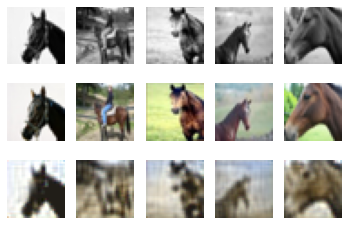

In [20]:
# train a new model with 50 epochs
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 50,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": True,
    "downsize_input": False,
}

args.update(args_dict)
cnn_epoch_50, train_losses_cnn_epoch_50, val_losses_cnn_epoch_50 = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [21]:
# results of cnn_epoch_50
print('Final Losses of cnn_epoch_50')
print('Training Loss:',MSELoss_dataset_evaluator(cnn_epoch_50,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn_epoch_50,val_rgb,val_grey,True))

Final Losses of cnn_epoch_50
Training Loss: 0.006963574793189764
Validation Loss: 0.007129046134650707


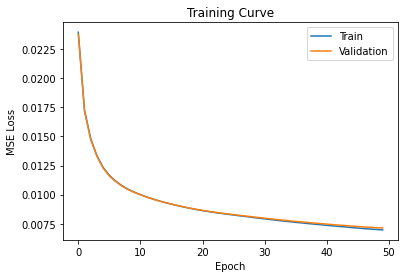

In [22]:
# training curve of cnn_epoch_50
plt.title("Training Curve")
plt.plot(range(50), train_losses_cnn_epoch_50, label="Train") # 1st epoch is epoch 0
plt.plot(range(50), val_losses_cnn_epoch_50, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

<font color='blue'>
RegressionCNN with 100 epochs
</font>

Beginning training ...
0 tensor(0.0337)
1 tensor(0.0183)
2 tensor(0.0161)
3 tensor(0.0148)
4 tensor(0.0139)
5 tensor(0.0131)
6 tensor(0.0125)
7 tensor(0.0119)
8 tensor(0.0115)
9 tensor(0.0110)
10 tensor(0.0107)
11 tensor(0.0104)
12 tensor(0.0101)
13 tensor(0.0098)
14 tensor(0.0096)
15 tensor(0.0094)
16 tensor(0.0092)
17 tensor(0.0091)
18 tensor(0.0089)
19 tensor(0.0088)
20 tensor(0.0086)
21 tensor(0.0085)
22 tensor(0.0084)
23 tensor(0.0082)
24 tensor(0.0081)
25 tensor(0.0080)
26 tensor(0.0079)
27 tensor(0.0078)
28 tensor(0.0077)
29 tensor(0.0077)
30 tensor(0.0076)
31 tensor(0.0075)
32 tensor(0.0074)
33 tensor(0.0073)
34 tensor(0.0073)
35 tensor(0.0072)
36 tensor(0.0071)
37 tensor(0.0071)
38 tensor(0.0070)
39 tensor(0.0070)
40 tensor(0.0069)
41 tensor(0.0068)
42 tensor(0.0068)
43 tensor(0.0067)
44 tensor(0.0067)
45 tensor(0.0066)
46 tensor(0.0066)
47 tensor(0.0065)
48 tensor(0.0065)
49 tensor(0.0064)
50 tensor(0.0064)
51 tensor(0.0064)
52 tensor(0.0063)
53 tensor(0.0063)
54 tensor(0.006

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 tensor(0.0055)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


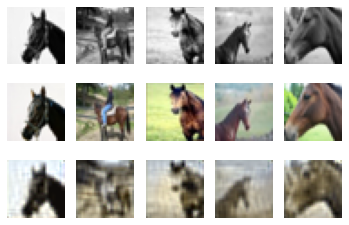

In [23]:
# train a new model with 100 epochs
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 100,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": True,
    "downsize_input": False,
}

args.update(args_dict)
cnn_epoch_100, train_losses_cnn_epoch_100, val_losses_cnn_epoch_100 = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [24]:
# results of cnn_epoch_100
print('Final Losses of cnn_epoch_100')
print('Training Loss:',MSELoss_dataset_evaluator(cnn_epoch_100,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn_epoch_100,val_rgb,val_grey,True))

Final Losses of cnn_epoch_100
Training Loss: 0.006112233269959688
Validation Loss: 0.006512922700494528


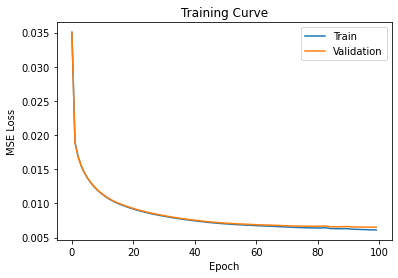

In [25]:
# training curve of cnn_epoch_100
plt.title("Training Curve")
plt.plot(range(100), train_losses_cnn_epoch_100, label="Train") # 1st epoch is epoch 0
plt.plot(range(100), val_losses_cnn_epoch_100, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

<font color='blue'>
RegressionCNN with 15 epochs
</font>

Beginning training ...
0 tensor(0.0550)
1 tensor(0.0259)
2 tensor(0.0188)
3 tensor(0.0164)
4 tensor(0.0147)
5 tensor(0.0135)
6 tensor(0.0125)
7 tensor(0.0117)
8 tensor(0.0111)
9 tensor(0.0106)
10 tensor(0.0103)
11 tensor(0.0099)
12 tensor(0.0097)
13 tensor(0.0095)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 tensor(0.0093)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


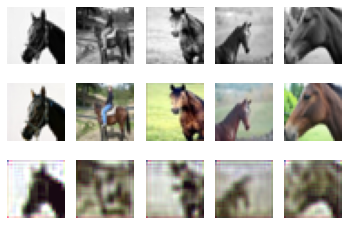

In [26]:
# train a new model with 15 epochs
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 15,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": True,
    "downsize_input": False,
}

args.update(args_dict)
cnn_epoch_15, train_losses_cnn_epoch_15, val_losses_cnn_epoch_15 = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [27]:
# results of cnn_epoch_15
print('Final Losses of cnn_epoch_15')
print('Training Loss:',MSELoss_dataset_evaluator(cnn_epoch_15,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn_epoch_15,val_rgb,val_grey,True))

Final Losses of cnn_epoch_15
Training Loss: 0.010116427205502987
Validation Loss: 0.010057940147817135


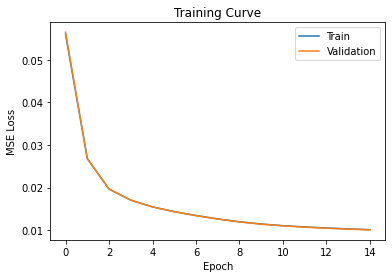

In [28]:
# training curve of cnn_epoch_15
plt.title("Training Curve")
plt.plot(range(15), train_losses_cnn_epoch_15, label="Train") # 1st epoch is epoch 0
plt.plot(range(15), val_losses_cnn_epoch_15, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

Answer:<br>
<font color='blue'>
I re-train 3 new models using different numbers of training epochs: 15, 50, 100, by changing hyperparameter epochs in args_dict.<br>
<br>
The training loss (of whole training set, not batch) with given initial setting (epochs = 25) is 0.01015.<br>
The training loss with epochs = 15 is 0.01011.<br>
The training loss with epochs = 50 is 0.00696.<br>
The training loss with epochs = 100 is 0.00611.<br>
So the training loss is decreasing as the number of epochs increases.<br>
<br>
The output images are getting clearer and more details are captured as the number of epochs increases. But the coloring style (what color at which part of image) does not show significant change, and the coloring is like the very early photos.
</font>

## Part 3. Skip Connections [8 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. We will introduce skip connections.

### Part (a) [4 pt]
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [3], and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.
Hint: You will need to use the function torch.cat.

In [29]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        # copied from RegressionCNN model
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters+num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3+1, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        # modified from RegressionCNN model
        in_layer1 = self.downconv1(x)
        out = self.downconv2(in_layer1)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(torch.cat((out,in_layer1),dim=1))
        out = self.finalconv(torch.cat((out,x),dim=1))
        return out

### Part (b) [2 pt]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. How does the result compare to the previous model? Did skip connections improve the validation loss and accuracy? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

Beginning training ...
0 tensor(0.0373)
1 tensor(0.0161)
2 tensor(0.0128)
3 tensor(0.0113)
4 tensor(0.0105)
5 tensor(0.0098)
6 tensor(0.0093)
7 tensor(0.0088)
8 tensor(0.0085)
9 tensor(0.0082)
10 tensor(0.0078)
11 tensor(0.0075)
12 tensor(0.0073)
13 tensor(0.0070)
14 tensor(0.0068)
15 tensor(0.0066)
16 tensor(0.0064)
17 tensor(0.0063)
18 tensor(0.0061)
19 tensor(0.0060)
20 tensor(0.0059)
21 tensor(0.0057)
22 tensor(0.0056)
23 tensor(0.0055)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0054)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


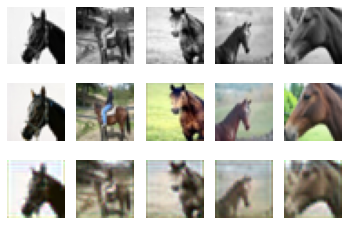

In [30]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet, train_losses_unet, val_losses_unet = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [31]:
# results of unet
print('Losses of unet')
print('Training Loss:',MSELoss_dataset_evaluator(unet,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(unet,val_rgb,val_grey,True))

Losses of unet
Training Loss: 0.006044295150786638
Validation Loss: 0.005938174668699503


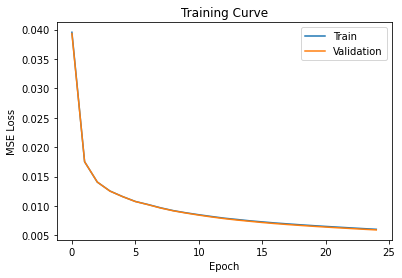

In [32]:
# training curve of unet
plt.title("Training Curve")
plt.plot(range(25), train_losses_unet, label="Train") # 1st epoch is epoch 0
plt.plot(range(25), val_losses_unet, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

Answer:<br>
<font color='blue'>
The result of UNet model with the same amount of epochs as the previous CNN and a batch size of 100 gives better result compare to the previous model. 
<br><br>
Skip connection improve validation loss (we are not using discriminator yet and there is no classification, thus no relevant accuracy) 
<br><br>
The skip connections improve the output qualitatively. The images get less blurry and become a bit more colorful. 
<br><br>
Give at least two reasons why skip connections might improve the performance of our CNN models:<br>
1. The network has 6 layers, the features at the bottom might only update a little compared to the features at the top layer due to gradient vanishing. Having direction connection from bottom to the top can help update the bottom features.<br> 
2. there might be some dead feature (gets to negative) due to the usage of ReLU activation. Skip connection brings feature reusablity.
3. There is loss of information during the downsampling process. Skip connection can help the model captures some structural details.
</font>

### Part (c) [2 pt]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs. Describe the effect of batch sizes on the training/validation loss, and the final image output.

<font color='blue'>
UNet with 50 batch size
</font>

Beginning training ...
0 tensor(0.0151)
1 tensor(0.0116)
2 tensor(0.0097)
3 tensor(0.0084)
4 tensor(0.0076)
5 tensor(0.0070)
6 tensor(0.0065)
7 tensor(0.0060)
8 tensor(0.0057)
9 tensor(0.0055)
10 tensor(0.0053)
11 tensor(0.0051)
12 tensor(0.0049)
13 tensor(0.0047)
14 tensor(0.0046)
15 tensor(0.0045)
16 tensor(0.0044)
17 tensor(0.0043)
18 tensor(0.0042)
19 tensor(0.0041)
20 tensor(0.0040)
21 tensor(0.0039)
22 tensor(0.0038)
23 tensor(0.0037)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0037)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


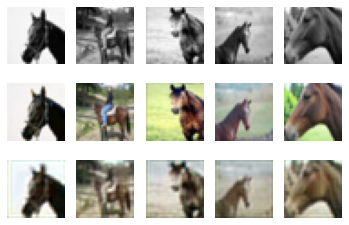

In [33]:
# complete the code
# Main training loop for UNet with 50 batch size
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_batch_50, train_losses_unet_batch_50, val_losses_unet_batch_50 = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [34]:
# results of unet_batch_50
print('Losses of unet_batch_50')
print('Training Loss:',MSELoss_dataset_evaluator(unet_batch_50,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(unet_batch_50,val_rgb,val_grey,True))

Losses of unet_batch_50
Training Loss: 0.004480935167521238
Validation Loss: 0.004500587470829487


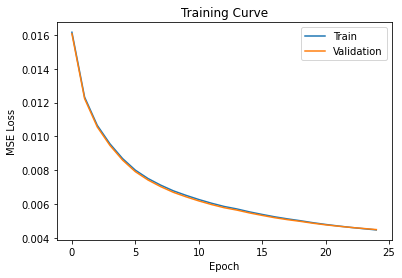

In [35]:
# training curve of unet_batch_50
plt.title("Training Curve")
plt.plot(range(25), train_losses_unet_batch_50, label="Train") # 1st epoch is epoch 0
plt.plot(range(25), val_losses_unet_batch_50, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

<font color='blue'>
UNet with 200 batch size
</font>

Beginning training ...
0 tensor(0.0182)
1 tensor(0.0148)
2 tensor(0.0127)
3 tensor(0.0116)
4 tensor(0.0107)
5 tensor(0.0100)
6 tensor(0.0094)
7 tensor(0.0089)
8 tensor(0.0085)
9 tensor(0.0081)
10 tensor(0.0078)
11 tensor(0.0076)
12 tensor(0.0073)
13 tensor(0.0071)
14 tensor(0.0069)
15 tensor(0.0067)
16 tensor(0.0065)
17 tensor(0.0064)
18 tensor(0.0063)
19 tensor(0.0061)
20 tensor(0.0060)
21 tensor(0.0059)
22 tensor(0.0058)
23 tensor(0.0057)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0056)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


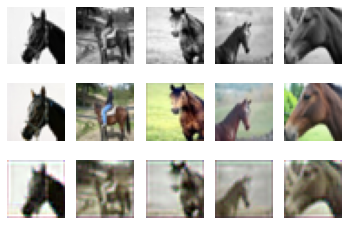

In [36]:
# complete the code
# Main training loop for UNet with 200 batch size
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 200,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_batch_200, train_losses_unet_batch_200, val_losses_unet_batch_200 = train_with_training_curve(args, train_rgb, train_grey, val_rgb, val_grey)

In [37]:
# results of unet_batch_200
print('Losses of unet_batch_200')
print('Training Loss:',MSELoss_dataset_evaluator(unet_batch_200,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(unet_batch_200,val_rgb,val_grey,True))

Losses of unet_batch_200
Training Loss: 0.005979232955724001
Validation Loss: 0.005921897944062948


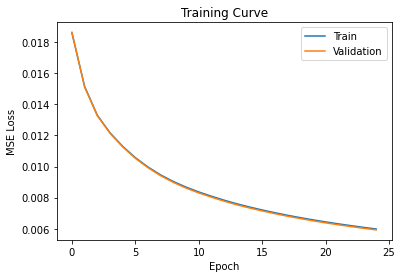

In [38]:
# training curve of unet_batch_200
plt.title("Training Curve")
plt.plot(range(25), train_losses_unet_batch_200, label="Train") # 1st epoch is epoch 0
plt.plot(range(25), val_losses_unet_batch_200, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

Answer:<br>
<font color='blue'>
With smaller batch size, both training loss and validation loss get smaller (batch size 50 vs. batch size 100 and 200). 
<br><br>
With smaller batch size, the outline of horse becomes less blurry. I can see clearer muscle curvature. And the fourth image has more area of light blue sky appearing for batch size 50, 100 than 200.

</font>

# PART B - Conditional GAN [30 pt]

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task.

## Part 1. Conditional GAN [15 pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. We will exploring the different architectures to identify and select our best image colourization model.

Note: This second half of the assignment should be started after the lecture on generative adversarial networks (GANs). 


### Part (a) [3 pt]
Modify the provided training code to implement a generator. Then test to verify it works on the desired input (Hint: you can reuse some of your earlier autoencoder models here to act as a generator)

<font color='red'>
Note:<br>
Based on the discussion on Piazza, noise is not required for this cGAN problem.
I will just use previous UNet as architecture of generator which takes only 
gray scale image as input (with ReLU changed to LeakyReLU for faster training)
</font>

In [39]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2))

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters+num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3+1, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        in_layer1 = self.downconv1(x)
        out = self.downconv2(in_layer1)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(torch.cat((out,in_layer1),dim=1))
        out = self.finalconv(torch.cat((out,x),dim=1))
        return out

In [40]:
#test generator architecture
# the generator should be able to take one grayscale image and transform it into
# colorful image of same size.

# initialize a generator
g = Generator(3,32,3,1)

# randomly created 5 gray scale images
img_rand_greyscale = torch.rand(5,1,32,32)

# randomly created 5 gray scale images
img_fake = g(img_rand_greyscale)

# verify dimension
print(img_fake.shape)


torch.Size([5, 3, 32, 32])


<font color='blue'>
The generator is working.
</font>

### Part (b) [3 pt]
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

In [41]:
# discriminator code
# I use the downsampling part of RegressionCNN followed by two fully connected layers
class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels + num_colours, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),)

        self.fc = nn.Sequential(
            nn.Linear(8*8*num_filters*2,8*num_filters*2),
            nn.LeakyReLU(0.2),
            nn.Linear(8*num_filters*2,num_filters*2),
            nn.LeakyReLU(0.2),
            nn.Linear(num_filters*2,1)
        )
    
    def forward(self, x, img_greyscale):
        
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        out = torch.cat((img_greyscale,x),dim=1)
        out = self.downconv1(out)
        out = self.downconv2(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out

In [42]:
# test discriminator architecture
# the generator should be able to take a grayscale image and a colorful image 
# then gives single entry output as binary prediction

# initialize a generator
d = Discriminator(3,32,3,1)

# randomly created 5 gray scale images
img_rand_greyscale = torch.rand(5,1,32,32)

# randomly created 5 gray scale images
discriminator_pred = d(img_fake,img_rand_greyscale)

# verify dimension
print(discriminator_pred.shape)


torch.Size([5, 1])


<font color='blue'>
The generator is working.
</font>

### Part (c) [3 pt]
Modify the provided training code to implement a conditional GAN.

In [99]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train_GAN(args, train_rgb, train_grey, val_rgb, val_grey, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    # I run with the default 5 here, no crashing
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters)
        discriminator = Discriminator(args.kernel,args.num_filters,3,1)


    # LOSS FUNCTION

    criterion =   nn.BCEWithLogitsLoss()                                                
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate/10)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []

    # fix a batch of 10 images for the purpose of displaying output images
    for i, (display_xs, display_ys) in enumerate(get_batch(train_grey, train_rgb, 100)):
        display_grey, display_real = get_torch_vars(display_xs, display_ys, args.gpu)

    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            
            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()
            
            # discriminator losses on real images 
            D_real = discriminator(img_real,img_grey)

            labels = torch.zeros(batch_size)  # real labels = 0
            if args.gpu:
                labels = labels.cuda()
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            fake_images = cnn(img_grey)

            D_fake = discriminator(fake_images,img_grey)
            labels = torch.ones(batch_size) # fake labels = 1
            if args.gpu:
                labels = labels.cuda()
            d_fake_loss = criterion(D_fake.squeeze(), labels)

            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # generator training
            g_optimizer.zero_grad()

            # generator losses on fake images
            outputs = cnn(img_grey)
          
            D_fake = discriminator(outputs,img_grey)
            labels = torch.zeros(batch_size) #flipped labels
            if args.gpu:
                labels = labels.cuda()
            
            # compute loss and update parameters
            g_loss = criterion(D_fake.squeeze(), labels)
            g_loss.backward()
            g_optimizer.step()

        outputs = cnn(display_grey)
        
        # print batch losses
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        
        # calculate training loss and validation loss
        train_losses.append(MSELoss_dataset_evaluator(cnn,train_rgb,train_grey,args.gpu))
        valid_losses.append(MSELoss_dataset_evaluator(cnn,val_rgb,val_grey,args.gpu))

    # only output images after training
    visual(display_grey, display_real, outputs, args.gpu, 1)
        
    return cnn, train_losses, valid_losses

### Part (d) [3 pt]
Train a conditional GAN for image colourization.

Beginning training ...
0 tensor(1.0572) tensor(1.0881)
1 tensor(2.8400) tensor(0.2672)
2 tensor(1.1450) tensor(1.0620)
3 tensor(1.2715) tensor(1.1213)
4 tensor(0.8870) tensor(1.4204)
5 tensor(0.8254) tensor(1.3410)
6 tensor(0.9376) tensor(1.2729)
7 tensor(0.8942) tensor(1.2347)
8 tensor(0.9909) tensor(1.1186)
9 tensor(0.8378) tensor(1.4900)
10 tensor(0.7662) tensor(1.4741)
11 tensor(0.7741) tensor(1.4834)
12 tensor(0.8680) tensor(1.3440)
13 tensor(0.8434) tensor(1.2460)
14 tensor(0.6971) tensor(1.5139)
15 tensor(0.7518) tensor(1.3509)
16 tensor(0.7262) tensor(1.4243)
17 tensor(0.7550) tensor(1.4074)
18 tensor(0.7664) tensor(1.4411)
19 tensor(0.8044) tensor(1.3954)
20 tensor(0.7391) tensor(1.3797)
21 tensor(0.8662) tensor(1.2511)
22 tensor(0.8641) tensor(1.2261)
23 tensor(1.0753) tensor(1.0776)
24 tensor(0.7104) tensor(1.4905)
25 tensor(0.9451) tensor(1.4117)
26 tensor(0.8403) tensor(1.2936)
27 tensor(0.6943) tensor(1.4751)
28 tensor(0.7148) tensor(1.4836)
29 tensor(0.8183) tensor(1.317

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 tensor(1.2322) tensor(1.2456)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


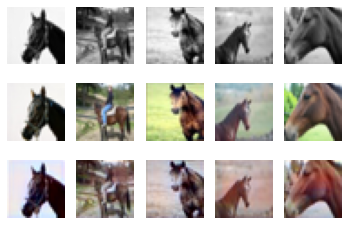

In [106]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn_cGAN, train_losses_cGAN, val_losses_cGAN = train_GAN(args, train_rgb, train_grey, val_rgb, val_grey)


In [107]:
# results of cnn_cGAN
print('Losses of cnn_cGAN')
print('Training Loss:',MSELoss_dataset_evaluator(cnn_cGAN,train_rgb,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn_cGAN,val_rgb,val_grey,True))

Losses of cnn_cGAN
Training Loss: 0.005998502019792795
Validation Loss: 0.005839889403432608


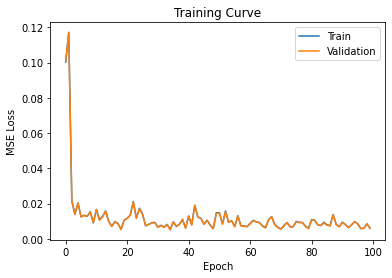

In [108]:
# training curve of cnn_cGAN
plt.title("Training Curve")
plt.plot(range(100), train_losses_cGAN, label="Train") # 1st epoch is epoch 0
plt.plot(range(100), val_losses_cGAN, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

### Part (e) [1 pt]
How does the performance of the cGAN compare with the autoencoder models that you tested in the first half of this assignment?

Answer:<br>
<font color='blue'>
In terms of training loss and validation loss, the performance is very close to the UNet model with batch size 100 and 200, but UNet model with batch size 50 is the best. (note that I reuse my UNet architecture for my generator)<br>
However, the output images of cGAN are visually better. The images are becoming colorful, instead of the style of very early photos in the previous autoencoder models. Some grass in the second image become green, and the brown horses in second and fourth images are getting brown. The horse in second image has also become less blurry.
</font>

### Part (f) [2 pt]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Answer:<br>
<font color='blue'>
RGB is a color space in which the perceptual difference between colors is directly related to distances between colors as represented by points in the color space, which is different from human perception. Human see different colors as distinct groups (like K-means in unsupervised learning, e.g. light red and deep red are both red), while RGB treats each color as vector of 3 values with magnitude. For instance, I notice that sometimes the green grass area are colored as yellow. To human, coloring grass as yellow is just as a mistake as coloring grass to other colors like blue and red. However, from RGB space, yellow consists of green component, which is actually a "better mistake" than blue and red. That is why the cGAN model has made large progression in colorization (the autoencoder mostly seems only caring about the structural information), but its training loss and validation loss have not become better (even higher MSE loss than UNet with 50 batch size). For colorization problem, it is more important that the model is willing to make the image colorful with correct coloring from human perception.
</font>

## Part 2. Exploration [10 pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you will be exploring at least one of several approaches towards improving our performance on the image colourization task. Some well known approaches you can consider include:

- lab colour space representation instead of RBG which simplifies the problem and requires you to predict two output channels instead of three
- k-means to represent RBG colourspace by 'k' distinct colours, this effectively changes the problem from regression to classification.

Other interesting approaches include:
- combining L1 loss along with the discriminator-based loss
- starting with a pretrained generator (i.e. Resnet)
- patch discriminator trained on local regions

A great example of some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>.

Note you are only required to pick one of the suggested modifications.

<font color='blue'>
I choose doing lab colour space representation. Two modified models are used: cGAN and UNet with 50 batch size (autoencoder with best training and validation losses)
</font>
<br><br>
<font color='red'>
Note:<br>
This is a colorization problem. Lab color space has format of 3 elements (L, a, b), with the first element being the lightness and the other two representing the color of pixel. And the given description above says "requires you to predict two output channels instead of three". So, I am assuming L value of pixel in lab color space is known, just like the gray scale image. I know the L value of lab color space is somehow correlated to the value gotten by converting image from grayscale to lab color space (a, b would be very close to 0), but the relationship is nonlinear and complicated. I will just extract the L value from colorful image as a known information, and predict a, b values of lab color space, which I think is matching the expectation of this part.
</font>

In [58]:
# for color convertion
from skimage import color

<font color='blue'>
cGAN with lab color space
</font>

In [182]:
# helper functions

# convert a numpy array of rgb images to lab images
def dataset_to_lab(dataset_rgb):
  n_imgs = dataset_rgb.shape[0]
  dataset_lab = color.rgb2lab(np.moveaxis(dataset_rgb, 1, -1))
  dataset_lab = np.moveaxis(dataset_lab, -1, 1)
  return dataset_lab


# visualize 5 train/test images
def visual_lab(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):
  
  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()
  
  if flag_torch: # flag_torch input is 1
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  img_fake = np.concatenate((img_real[:,:,:,0:2],img_fake),axis=3)
  img_fake = np.delete(img_fake,1,axis=3)
  img_fake = color.lab2rgb(img_fake)
  img_real = color.lab2rgb(img_real)

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

def train_GAN_lab(args, train_lab, train_ab, train_grey, val_lab, val_ab, val_grey, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    # I run with the default 5 here, no crashing
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters,2,1)
        discriminator = Discriminator(args.kernel,args.num_filters,2,1)


    # LOSS FUNCTION

    criterion =   nn.BCEWithLogitsLoss()                                                
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate/10)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []

    # fix a batch of 10 images for the purpose of displaying output images
    for i, (display_xs, display_ys) in enumerate(get_batch(train_grey, train_lab, 100)):
        display_grey, display_real = get_torch_vars(display_xs, display_ys, args.gpu)

    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_ab, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            
            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()
            
            # discriminator losses on real images 
            D_real = discriminator(img_real,img_grey)
            
            labels = torch.zeros(batch_size)  # real labels = 0
            if args.gpu:
                labels = labels.cuda()
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            fake_images = cnn(img_grey)

            D_fake = discriminator(fake_images,img_grey)
            labels = torch.ones(batch_size) # fake labels = 1
            if args.gpu:
                labels = labels.cuda()
            d_fake_loss = criterion(D_fake.squeeze(), labels)

            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # generator training
            g_optimizer.zero_grad()

            # generator losses on fake images
            outputs = cnn(img_grey)
          
            D_fake = discriminator(outputs,img_grey)
            labels = torch.zeros(batch_size) #flipped labels
            if args.gpu:
                labels = labels.cuda()
            
            # compute loss and update parameters
            g_loss = criterion(D_fake.squeeze(), labels)
            g_loss.backward()
            g_optimizer.step()

        outputs = cnn(display_grey)
        
        # print batch losses
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        
        # calculate training loss and validation loss
        train_losses.append(MSELoss_dataset_evaluator(cnn,train_ab,train_grey,args.gpu))
        valid_losses.append(MSELoss_dataset_evaluator(cnn,val_ab,val_grey,args.gpu))

    # only output images after training
    visual_lab(display_grey, display_real, outputs, args.gpu, 1)
        
    return cnn, train_losses, valid_losses

In [149]:
# derive lab images
train_lab = dataset_to_lab(train_rgb)
val_lab = dataset_to_lab(val_rgb)
train_ab = train_lab[:,1:3,:,:]
val_ab = val_lab[:,1:3,:,:]
train_l = train_lab[:,0,:,:]
val_l = val_lab[:,0,:,:]

Beginning training ...
0 tensor(1.1729) tensor(0.9394)
1 tensor(1.8351) tensor(0.4953)
2 tensor(2.2924) tensor(0.4464)
3 tensor(2.0177) tensor(0.8874)
4 tensor(2.2654) tensor(0.7279)
5 tensor(2.3220) tensor(0.4431)
6 tensor(2.3222) tensor(0.7138)
7 tensor(2.3136) tensor(0.4596)
8 tensor(2.0865) tensor(0.5304)
9 tensor(2.0279) tensor(0.5835)
10 tensor(2.6773) tensor(0.4008)
11 tensor(3.6086) tensor(0.2104)
12 tensor(3.0993) tensor(0.3105)
13 tensor(3.4791) tensor(0.1817)
14 tensor(3.0594) tensor(0.2125)
15 tensor(3.1109) tensor(0.2610)
16 tensor(2.4638) tensor(0.3433)
17 tensor(2.9190) tensor(0.5351)
18 tensor(3.8660) tensor(0.1915)
19 tensor(3.9309) tensor(0.1568)
20 tensor(2.1520) tensor(0.9830)
21 tensor(2.5710) tensor(0.4349)
22 tensor(3.0264) tensor(0.4195)
23 tensor(2.2776) tensor(0.4612)
24 tensor(2.7716) tensor(0.3413)
25 tensor(2.0419) tensor(0.6018)
26 tensor(2.7722) tensor(0.4424)
27 tensor(2.7328) tensor(0.3999)
28 tensor(2.5765) tensor(0.3812)
29 tensor(2.0338) tensor(0.522

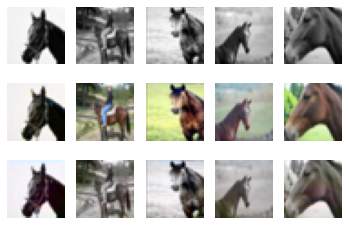

In [187]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001/2, 
    "batch_size": 50,
    "epochs": 30,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn_cGAN_lab, train_losses_cGAN_lab, val_losses_cGAN_lab = train_GAN_lab(args, train_lab, train_ab, train_grey, val_lab, val_ab, val_grey)

In [188]:
# results of cnn_cGAN_lab
print('Losses of cnn_cGAN_lab')
print('Training Loss:',MSELoss_dataset_evaluator(cnn_cGAN_lab,train_ab,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(cnn_cGAN_lab,val_ab,val_grey,True))

Losses of cnn_cGAN_lab
Training Loss: 173.05653381347656
Validation Loss: 168.291259765625


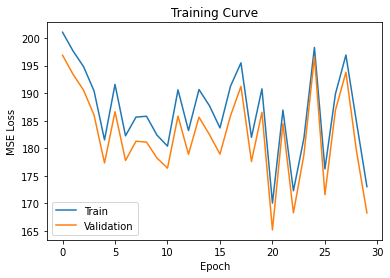

In [189]:
# training curve of cnn_cGAN_lab
plt.title("Training Curve")
plt.plot(range(30), train_losses_cGAN_lab, label="Train") # 1st epoch is epoch 0
plt.plot(range(30), val_losses_cGAN_lab, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

Discussion:
<font color='blue'><br>
The training curve starts to shoot up after initial progression, so cGAN stops early at epoch 30. The cGAN with lab is very volatile, not even as good as cGAN with RGB visually. (I also checked the output images using epoch 100, not getting any better visually) This might be due to the fact that with 1 less color dimension, there is loss of information, so the model complexity upper limit is lowered... Or just the archeture needs to be adjusted (I have tried different hyperparameters, but cGAN with lab is not getting better than cGAN with RGB).
</font>
<br>
-------------------------------------------------------------------------

<font color='blue'>
UNet with batch size 50 and with lab color space
</font>

In [195]:
# modified version for lab color space
def train_unet_lab(args, train_lab, train_ab, train_grey, val_lab, val_ab, val_grey, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters,num_colours=2)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()
    train_losses = []
    valid_losses = []
    valid_accs = []
    
    # fix a batch of 10 images for the purpose of displaying output images
    for i, (display_xs, display_ys) in enumerate(get_batch(train_grey, train_lab, 100)):
        display_grey, display_real = get_torch_vars(display_xs, display_ys, args.gpu)
    

    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_ab, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        
        print(epoch, loss.cpu().detach())

        # calculate training loss and validation loss
        train_losses.append(MSELoss_dataset_evaluator(gen,train_ab,train_grey,args.gpu))
        valid_losses.append(MSELoss_dataset_evaluator(gen,val_ab,val_grey,args.gpu))

        outputs = gen(display_grey)
    
    # only output images after training
    if args.plot:
        visual_lab(display_grey, display_real, outputs, args.gpu, 1)

    return gen, train_losses, valid_losses

# did not place num_colours to be output size but number 3 instead previously, so adjusting UNet Architecture here
class UNet_lab(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        # copied from RegressionCNN model
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters+num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3+1, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        # modified from RegressionCNN model
        in_layer1 = self.downconv1(x)
        out = self.downconv2(in_layer1)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(torch.cat((out,in_layer1),dim=1))
        out = self.finalconv(torch.cat((out,x),dim=1))
        return out

Beginning training ...
0 tensor(134.1505)
1 tensor(120.8440)
2 tensor(109.3579)
3 tensor(100.4833)
4 tensor(93.4374)
5 tensor(89.9839)
6 tensor(88.5586)
7 tensor(88.7374)
8 tensor(88.5311)
9 tensor(88.4364)
10 tensor(87.0134)


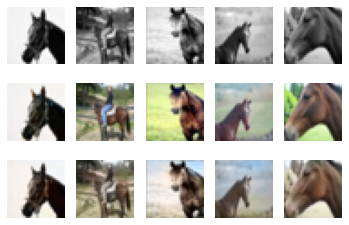

In [206]:
# complete the code
# Main training loop for UNet with 50 batch size
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet_lab",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 11,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_batch_50_lab, train_losses_unet_batch_50_lab, val_losses_unet_batch_50_lab = train_unet_lab(args, train_lab, train_ab, train_grey, val_lab, val_ab, val_grey)

In [207]:
# results of unet_batch_50_lab
print('Losses of cnn_cGAN_lab')
print('Training Loss:',MSELoss_dataset_evaluator(unet_batch_50_lab,train_ab,train_grey,True))
print('Validation Loss:',MSELoss_dataset_evaluator(unet_batch_50_lab,val_ab,val_grey,True))

Losses of cnn_cGAN_lab
Training Loss: 110.16651153564453
Validation Loss: 113.34031677246094


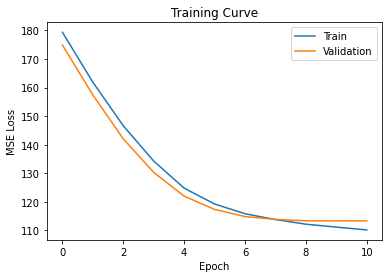

In [210]:
# training curve of cnn_cGAN_lab
plt.title("Training Curve")
plt.plot(range(11), train_losses_unet_batch_50_lab, label="Train") # 1st epoch is epoch 0
plt.plot(range(11), val_losses_unet_batch_50_lab, label="Validation") # 1st epoch is epoch 0
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.show()

<font color='blue'>
The UNet model training is stopped at epoch 11, or there would be growing overfitting. In terms of losses, UNet with lab is better than cGAN with lab. In addition, this UNet models has generated the best images visually. The horse shape and texture of muscle are the clearest. The images are the most colorful and the coloring is correct. Brown horses are brown, grass is green, and sky is blue. This model is considered the best among all the models developed.
</font>

## Part 3. New Data [5 pt]
Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code.

<font color='blue'>
I manually selected 25 images of different types (season, indoor/outdoor, single horse/multiple horses, horses of different types, etc.). I downloaded these images and uploaded to the Colab Working Directory to process.<br><br>
The best model I use is UNet with batch size 50 and label color space.
</font>

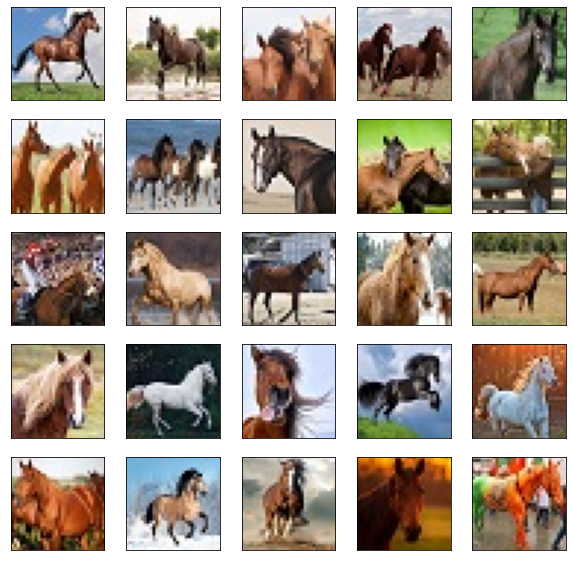

In [249]:
# provide your code here
# load new images
import torchvision
from torchvision import datasets, models, transforms

image = torchvision.io.read_image(str(1)+'.jpg')
data_transform = transforms.Resize(size=(32,32))
image = data_transform(image).reshape(1,3,32,32)
for i in range(2,26):
  image_next = torchvision.io.read_image(str(i)+'.jpg')
  image = torch.cat((image,data_transform(image_next).reshape(1,3,32,32)),axis=0)

new_rgb = torch.moveaxis(image, 1, -1)

# show the new images in rgb
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(new_rgb[idx,:,:,:])


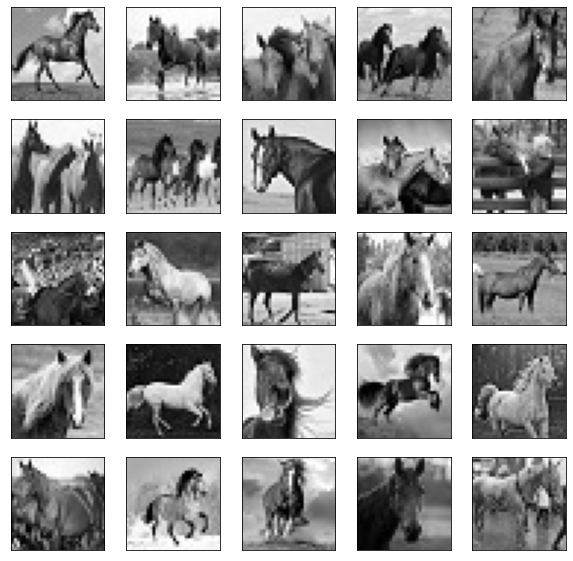

In [258]:
# convert new images to grayscale
new_grey = torch.mean(new_rgb / 256, axis=3, keepdims=True).reshape(25,32,32)

# show the new images in grayscale
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(new_grey[idx,:,:],cmap='gray')

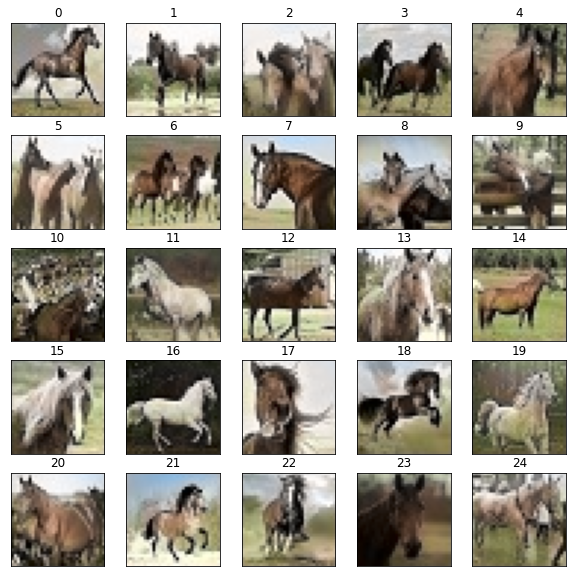

In [297]:
# generate fake images
new_grey_input = new_grey.reshape(25,1,32,32)
#unet_batch_50_lab = unet_batch_50_lab.cpu().detach()
best_model = unet_batch_50_lab
fake_ab =  best_model(new_grey_input)

# pass lightness data (not as unknown like the other two color entries: a, b)
fake_l = color.rgb2lab(new_rgb.numpy())[:,:,:,0]
fake_l = torch.from_numpy(fake_l).reshape(25,1,32,32)

# assembly the fake images generated
fake_lab = torch.cat((fake_l,fake_ab),axis=1)
fake_lab = torch.moveaxis(fake_lab,1,-1)
fake_lab = fake_lab.cpu().detach()
fake_lab = fake_lab.numpy()
fake_lab = color.lab2rgb(fake_lab)

# show the new images in rgb
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    ax.set_title(str(idx))
    plt.imshow(fake_lab[idx,:,:,:])


<font color='blue'>
The result is not perfect but impressive to me. The horses outline and muscle texture are very clear. The generator is very good at identifying brown and white horses. It is able to color differently for horses of different colors in same image (image 11). It is able to color green grass, blue sky, and even white snow (image 21). Great performance in terms of structural information, and very good performance in coloring. Some colorings are wrong but horse-relevant and does not appear to be abnormal visually.
</font>

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [110]:
%%shell
jupyter nbconvert --to html LAB_3_Generating_Data.ipynb

[NbConvertApp] Converting notebook try.ipynb to html
[NbConvertApp] Writing 42821387 bytes to try.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus